# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Statistical Analysis
<p>The following statistical analysis will try to establish whether race has a significant impact on the rate of callbacks for resumes by answering the following questions:<p>

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

#### Resources
* Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states

# Set up the environment

In [1]:
import warnings
warnings.filterwarnings('ignore')

# pretty print all cell's output and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# import modules
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

In [3]:
# read the data and look at the structure
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


## Callback Frequency by 'race' and gender
The EDA shows that the great majority of candidates are female with white-sounding names having a higher callback rate in both groups.

In [4]:
# number of callbacks for black-sounding names
w = data[data.race=='w']
b = data[data.race=='b']

# counts by callback, sex and race
data.groupby(['race','sex','call' ]).size()

race  sex  call
b     f    0.0     1761
           1.0      125
      m    0.0      517
           1.0       32
w     f    0.0     1676
           1.0      184
      m    0.0      524
           1.0       51
dtype: int64

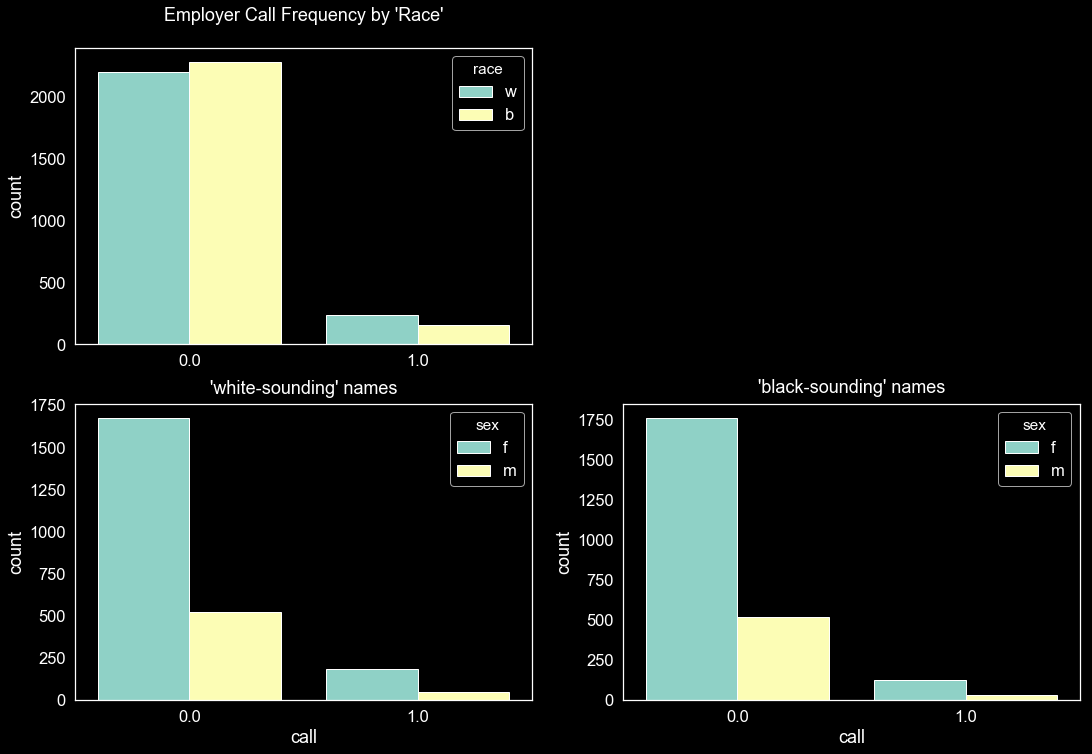

In [5]:
# plot job applications and callback results by race and gender
_=sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
_=plt.style.use(['dark_background'])
_=plt.rcParams['figure.figsize'] = [18,12]

# plot permutation results
_=plt.subplot(2,2,1)
#_=plt.rcParams['figure.figsize'] = [10,6]
_=sns.countplot(x="call", hue="race", data=data, saturation=0.95, )
_=plt.title("Employer Call Frequency by 'Race'\n")
_=plt.xlabel('')

# set parameters for plots by race
#_=plt.suptitle("Callback Frequency by 'Race' and Gender\n")
_=plt.subplot(2,2,3)
_=plt.title("'white-sounding' names", pad=10)
_=sns.countplot(x="call", hue="sex", data=w, saturation=0.95, )

# plot for black-sounding names
_=plt.subplot(2,2,4)
_=plt.title("\n\n'black-sounding' names", pad = 10.5)
_=sns.countplot(x="call", hue="sex", data=b, saturation=0.95, )

In [6]:
# callback frequency by race
print('callbacks for black-sounding names:',sum(b.call))
print('callbacks for white-sounding names:',sum(w.call))

callbacks for black-sounding names: 157.0
callbacks for white-sounding names: 235.0


<div class="span5 alert alert-success">
<p>1. What test is appropriate for this problem? Does CLT apply?</p>
<p>Since the objective of this analysis is to determine whether the probability distribution of ‘call’, a Bernoulli random variable, is different by population race, ‘b’ and ‘w’, we can conduct a <b>two-sample t-test </b>comparing the black-sounding names data sample with the white-sounding names set. Since the race values were assigned randomly, they are independent, the sample size is large, it’s less than 10% of the population, and data contains a binomial random variable, the CLT applies.</p>
</div>

<div class="span5 alert alert-success">
<p>2. What are the null and alternate hypotheses?</p>
<p>The null hypothesis is that holding everything else constant, the probability of receiving a call back from an employer is the same for black and white sounding names. The alternative hypothesis is that there is a statistically significant difference between the two groups.</p>
<p>$H_0$: 'b' = 'w' </p>
<p>$H_A$: 'b' $\neq$ 'w'</p>
<p>$\alpha$ = 0.05</p>
</div>

<div class="span5 alert alert-success">
3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
</div>

## Frequentist Approach to Probability

In [7]:
# convert data to array for easier analysis
w_calls = w.call.values
b_calls = b.call.values

# proportion of calls from employers by 'race'
w_prop = np.sum(w_calls)/len(w_calls)
b_prop = np.sum(b_calls)/len(b_calls)

print("Proportion call backs 'w':",np.round((w_prop),4),
      "\nProportion call backs 'b':",np.round((b_prop),4),)

Proportion call backs 'w': 0.0965 
Proportion call backs 'b': 0.0645


<p>Based on the observed data, 'white-sounding’ names seem to receive a slightly higher percentage of calls from employers than resumes with ‘black-sounding’ names. While 9.65% of ‘white’ applicants received an interview request, only 6.45% of ‘black’ applicants were invited to interview. However, to see the likelihood of this happening again, we randomly sample the data ignoring the ‘labels’ and see if there is a difference between the two groups.</p>

## Bootstrap Approach to Probability

In [8]:
# calculate the observed difference
def observed_diff(array1, array2):
    frac1 = np.sum(array1)/len(array1)
    frac2 = np.sum(array2)/len(array2)
    return frac1 - frac2

obs_diff = observed_diff(w_calls, b_calls)

# define permutation function
def permutation_samples(array1, array2):
    """Return a permutation sample from two arrays"""
    # concatenate the two arrays to 'remove' the labels and create the permuation sample
    both_df = np.concatenate((array1, array2))

    # mix the data
    both_perms = np.random.permutation(both_df)

    # randomly separate the data
    perm_1 = both_perms[:len(array1)]
    perm_2 = both_perms[len(array1):]
    
    return perm_1, perm_2

# define a function to compute n size permutation replicates
def permutation_replicates(array1, array2, function, size):
    """Return array of sample statistics computer from a permutation sample"""
    
    # create an empty array to store the replicates
    replicates_array = np.empty(10000)
    
    # create the permutation sample of size n
    for i in range(size):
        ps1, ps2 = permutation_samples(array1, array2)
    
        # compute the test statistic
        replicates_array[i] = function(ps1, ps2)
    
    return replicates_array

# critical value for 
critical_value = 1.96

# standard error individual arrays
se_w = stats.sem(w_calls)
se_b = stats.sem(b_calls)

# standard error of the differences between the two independent arrays
se = np.sqrt((np.var(w_calls)/len(w_calls)) + np.var(b_calls)/len(b_calls))

# margin of error and confidence intervals
me = critical_value * se
ci = obs_diff + np.array([-1,1])*me

# t-statistc 
t_test =stats.ttest_ind(w_calls, b_calls)

# set the random seed
np.random.seed(88)

# combine arrays, ignore the labels and create a new set of arrays to compare if the results are the same
perm_sample1, perm_sample2 = permutation_samples(b_calls, w_calls)

# get the permutation replicates
perm_reps = permutation_replicates(w_calls, b_calls, observed_diff, 10000)

# calculate the probability
p_value = np.sum(perm_reps >=obs_diff)/len(perm_reps)

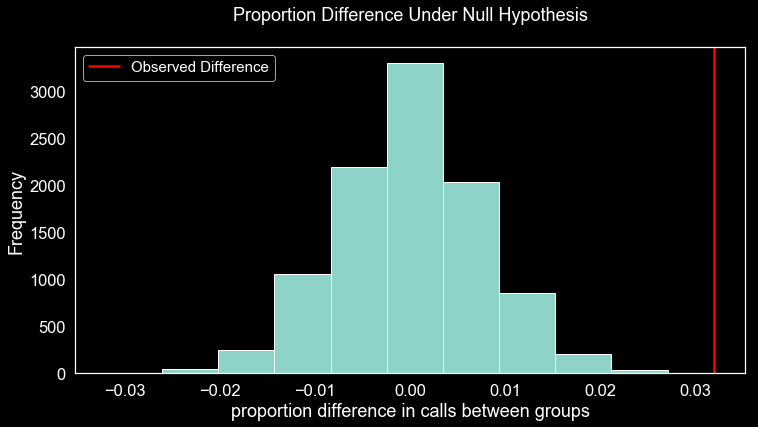

In [9]:
_=plt.style.use(['dark_background'])
_=plt.rcParams['figure.figsize'] = [12,6]
_=plt.title('Proportion Difference Under Null Hypothesis\n')
_=plt.axvline(obs_diff, color = 'red', label = 'Observed Difference')
_=plt.legend(['Observed Difference'], fontsize = 15)
_=plt.hist(perm_reps)
_=plt.xlabel('proportion difference in calls between groups')
_=plt.ylabel('Frequency')

In [10]:
print("\nObserved difference:",np.round((obs_diff),4),
      '\nStandard error of the differences:',np.round((se),4),
      '\nMargin of error:', np.round((me),4),
      '\nConfidence interval:', np.round((ci),4),
      '\nt-statistics:', np.round((t_test[0]),4),
      '\nP-value:',p_value
     )


Observed difference: 0.032 
Standard error of the differences: 0.0078 
Margin of error: 0.0153 
Confidence interval: [0.0168 0.0473] 
t-statistics: 4.1147 
P-value: 0.0


</p>After simulating the job application results 10,000 times, the difference in the proportion of calls received by one group vs. the other was between +-2.5%. Since the observed difference was 3.2%, we see the none of the simulations reached a difference that was at least this high. The result for the t-statistic, which was 4.115 (higher that the t critical value of 1.96) and the p-value was 0.0, suggests that the difference in call rates is statistically significant at the 0.05 significance level. Hence, we reject the null hypothesis, that everything else being equal, the implication of race has no impact on interview requests.</p>

### Race and Name as a Factor
<p>Does the analysis mean that race/name is the most important factor in callback success?</p>
<p>While the previous analysis showed that resumes with ‘white-sounding’ names did in fact receive a higher percentage of calls to interview, it does not conclude that race is the single most important factor in callback success. Other external factors, such as business’s location, how skills are weighted by job title or even human bias can all play a role in the results, which may not all be measured by the model</p>